In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.logger import logger

In [7]:
def load_data(filepath):
    """Safely load data from CSV, handling common errors."""
    try:
        data = pd.read_csv(filepath)
        if data.empty:
            logger.warning(f"Warning: {filepath} is empty.")
            return None
        return data
    except FileNotFoundError:
        logger.error(f"Error: File {filepath} not found.")
        return None
    except pd.errors.EmptyDataError:
        logger.error(f"Error: File {filepath} is empty, no data to load.")
        return None
    except Exception as e:
        logger.exception(f"An unexpected error occurred: {e}")
        return None

def calculate_percentage(data):
    """Calculate percentage of significant changes in electrode data."""
    # Check if the input data is valid (not None or empty)
    if data is None:
        return None, None

    total_electrodes = len(data)  # Total number of electrodes used in paper

    # Calculate the number of significant increases based on p-value and PSC
    sig_increases = data[(data['p-value'] <= 0.05) & (data['PSC'] > 0)].shape[0]

    # Calculate the number of significant decreases based on p-value and PSC
    sig_decreases = data[(data['p-value'] <= 0.05) & (data['PSC'] <= 0)].shape[0]

    # Calculate the percentage of significant increases
    increase_percent = (sig_increases / total_electrodes) * 100

    # Calculate the percentage of significant decreases
    decrease_percent = (sig_decreases / total_electrodes) * 100

    return increase_percent, decrease_percent  # Return the calculated percentages



def calculate_significant_changes_percentage_by_type(data):
    """Calculates the percentage of electrodes showing significant changes by frequency type."""

    # Check if the input data is valid (not None or empty)
    if data is None:
        logger.warning("No data provided or data is empty.")
        return None

    # Get the total number of electrodes
    total_electrodes = len(data)
    # Initialize a dictionary to store counts for each category (significant and non-significant changes)
    results = {'sig_pos': 0, 'sig_neg': 0, 'non_sig_pos': 0, 'non_sig_neg': 0}

    # Define the 'p-value' and 'PSC' columns
    required_columns = {'p-value', 'PSC'}
    # Check if the data contains the necessary columns
    if not required_columns.issubset(data.columns):
        logger.error(f"Data is missing required columns. Required: {required_columns}")
        return None

    # Loop through each row in the data to classify and count changes based on p-value and PSC
    for _, row in data.iterrows():
        # If the p-value is 0.05 or less and the Percent Signal Change (PSC) is non-negative,
        # it's considered a significant positive change.
        if row['p-value'] <= 0.05 and row['PSC'] >= 0:
            results['sig_pos'] += 1
        # If the p-value is 0.05 or less and the PSC is negative,
        # it's considered a significant negative change.
        elif row['p-value'] <= 0.05 and row['PSC'] < 0:
            results['sig_neg'] += 1
        # If the p-value is greater than 0.05 and the PSC is non-negative,
        # it's considered a non-significant positive change.
        elif row['p-value'] > 0.05 and row['PSC'] >= 0:
            results['non_sig_pos'] += 1
        # If the p-value is greater than 0.05 and the PSC is negative,
        # it's considered a non-significant negative change.
        elif row['p-value'] > 0.05 and row['PSC'] < 0:
            results['non_sig_neg'] += 1

    # Calculate the percentage of each category by dividing the count by the total number of electrodes
    # and multiplying by 100 to get a percentage.
    for key in results:
        results[key] = (results[key] / total_electrodes) * 100

    return results

In [6]:
# Loading data
data_hg = load_data('Band5-HG Results.csv')
data_lg = load_data('Band4-Gamma Results.csv')
data_beta = load_data('Band3-Beta Results.csv')
data_alpha = load_data('Band2-Alpha Results.csv')
data_theta = load_data('Band1-Theta Results.csv')
data_delta = load_data('Band0-Delta Results.csv')

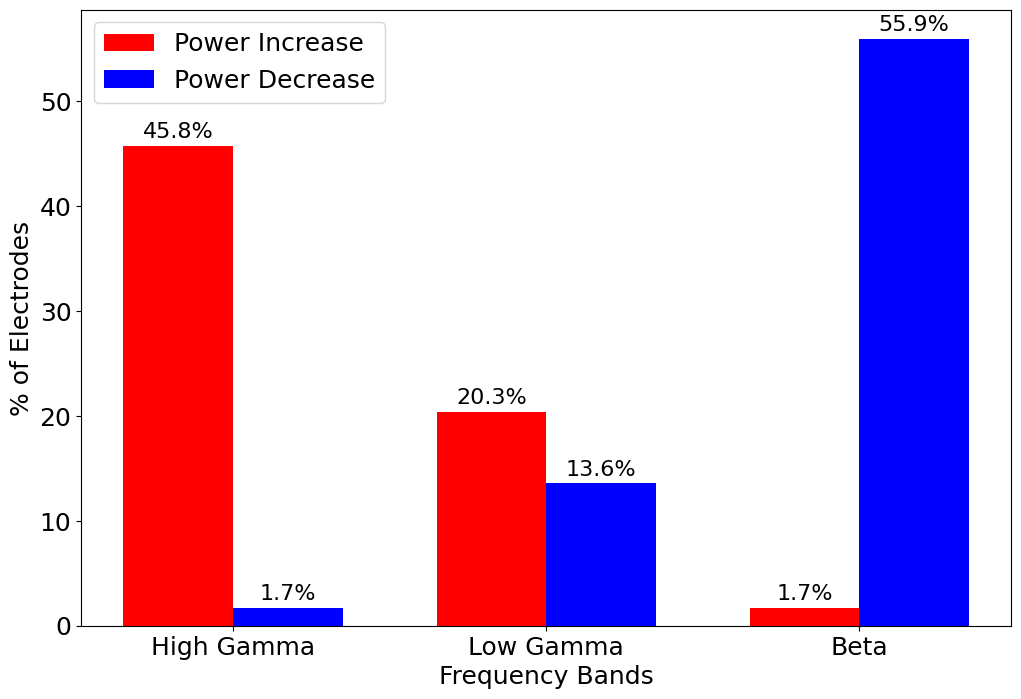

In [10]:
# Ensurig all datasets are properly loaded and processed
if data_hg is not None and data_lg is not None and data_beta is not None:
    # Calculating percentages
    hg_inc_percent, hg_dec_percent = calculate_percentage(data_hg)
    lg_inc_percent, lg_dec_percent = calculate_percentage(data_lg)
    beta_inc_percent, beta_dec_percent = calculate_percentage(data_beta)

    # If none of the inc/dec dataframes is None, enter here
    if None not in (hg_inc_percent, hg_dec_percent, lg_inc_percent, lg_dec_percent, beta_inc_percent, beta_dec_percent):

        # Plotting
        fig, ax = plt.subplots(figsize=(12,8))
        categories = ['High Gamma', 'Low Gamma', 'Beta']
        increases = [hg_inc_percent, lg_inc_percent, beta_inc_percent]
        decreases = [hg_dec_percent, lg_dec_percent, beta_dec_percent]

        index = range(len(categories))
        bar_width = 0.35

        bars1 = ax.bar(index, increases, bar_width, label='Power Increase', color='red')
        bars2 = ax.bar([i + bar_width for i in index], decreases, bar_width, label='Power Decrease', color='blue')

        # Adding value labels
        for bar in bars1 + bars2:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                        textcoords="offset points", ha='center', va='bottom', fontsize=16)

        ax.set_xlabel('Frequency Bands', fontsize=18)
        ax.set_ylabel('% of Electrodes', fontsize=18)
        ax.set_xticks([i + bar_width / 2 for i in index])
        ax.set_xticklabels(categories, fontsize=18)
        ax.legend(fontsize=18)
        plt.yticks(rotation=0, fontsize=18)

        plt.show()
    else:
        logger.error("Calculation error: Could not compute percentages for one or more bands.")
else:
    logger.error("Error: Data loading failed for one or more bands.")

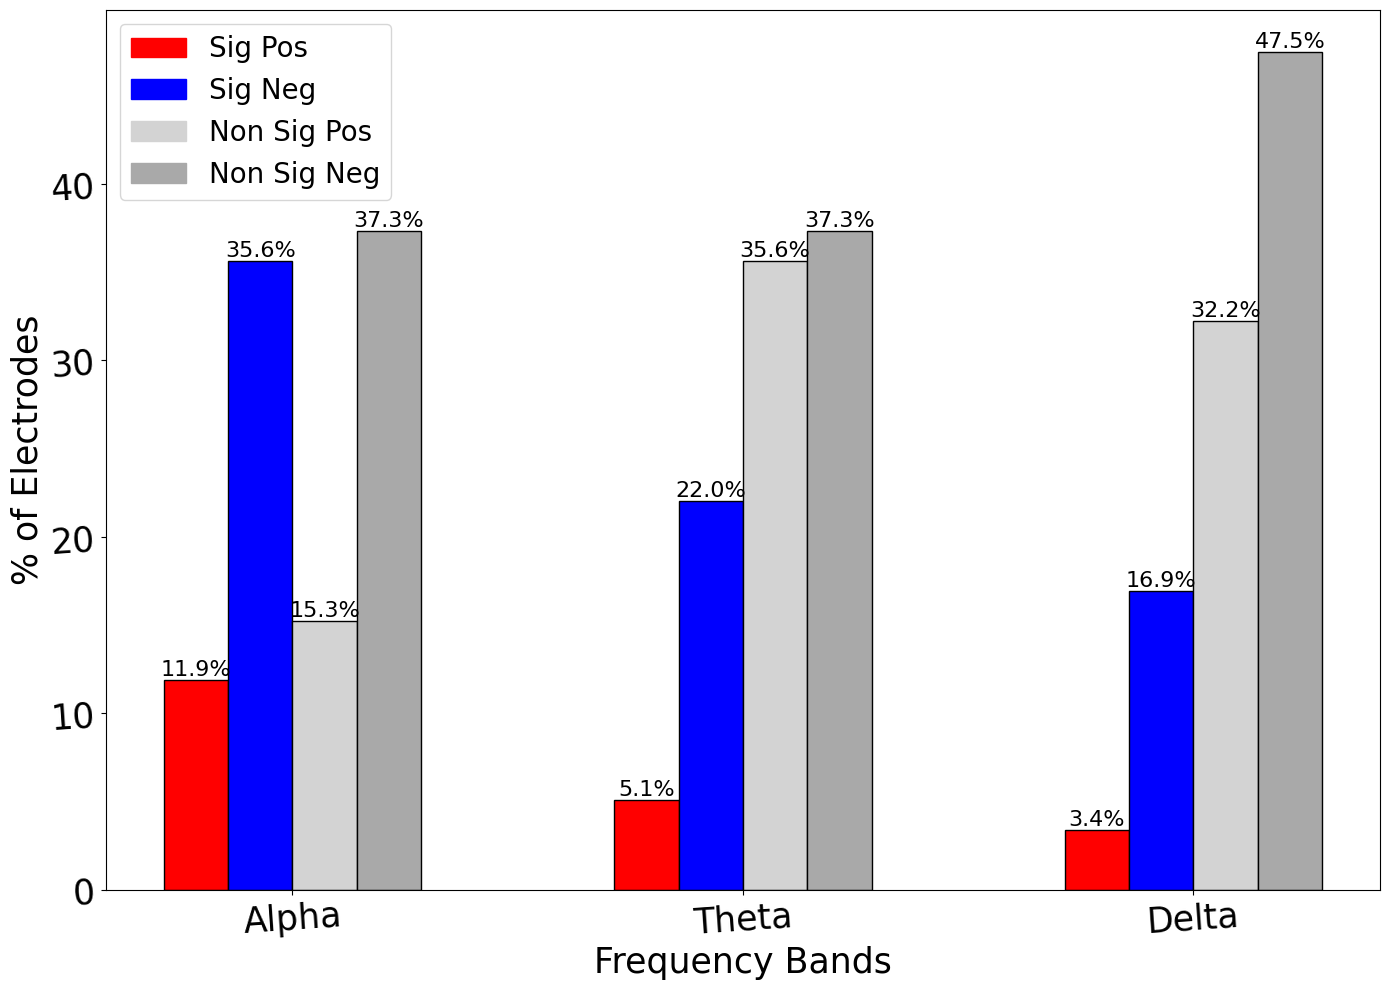

In [10]:
results_alpha = calculate_significant_changes_percentage_by_type(data_alpha)
results_theta = calculate_significant_changes_percentage_by_type(data_theta)
results_delta = calculate_significant_changes_percentage_by_type(data_delta)

categories = ['sig_pos', 'sig_neg', 'non_sig_pos', 'non_sig_neg']
frequencies = ['Alpha', 'Theta', 'Delta']
results = {'Alpha': results_alpha, 'Theta': results_theta, 'Delta': results_delta}

category_colors = {
    'sig_pos': 'red',
    'sig_neg': 'blue',
    'non_sig_pos': 'lightgrey',
    'non_sig_neg': 'darkgrey'
}

fig, ax = plt.subplots(figsize=(14, 10))

# Spacing between groups
group_width = len(categories) * 0.2
extra_space = 0.5  # Space between groups
group_starts = np.array([0, 1, 2]) * (group_width + extra_space + 0.1)  # Adjusted for better visual separation

for i, freq in enumerate(frequencies):
    offsets = group_starts[i] + np.arange(len(categories)) * 0.2
    percentages = [results[freq][cat] for cat in categories]
    colors = [category_colors[cat] for cat in categories]
    bars = ax.bar(offsets, percentages, 0.2, color=colors, edgecolor='black')

    # Percentage values on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom', fontsize=16)

# ax.set_title('Percentage of Electrodes Showing Significant and Non-Significant Power Changes by Frequency Band')
ax.set_xlabel('Frequency Bands', fontsize=25)
ax.set_ylabel('% of Electrodes', fontsize=25)

# Legend to reflect the types of changes
legend_elements = [plt.Rectangle((0,0),1,1, color=category_colors[cat], label=cat.replace('_', ' ').title()) for cat in categories]
ax.legend(handles=legend_elements, fontsize=20)

ax.set_xticks(group_starts + 1.5 * 0.2)
ax.set_xticklabels(frequencies, fontsize=25)
plt.yticks(rotation=4, fontsize=25)
plt.xticks(rotation=4, fontsize=25)
plt.tight_layout()

plt.show()
